# Kaggle Titanic Challenge


## Research Questions
- Are there information that can be extracted from the existing fields?
- What features are the best candidates for prediction?

## Kaggle Challenge
This notebook outlines my research journvey creating a predictive model based on the data provided by the competition. 

## Python as a Report Platform

The first question is a serious question, somewhat, for a person that believes that R is really the place to start with data analysis. Microsoft has recently added R and Python to Microsoft SQL Server. Splunk also has a machine learning toolkit for predictive modeling. 

# Getting and Cleaning Data
A 2016 Forbes article reports that a data scientist survey indicated that their most time consuming and least satisfying [1]. A Google search on the path of others on this challenge starts, as would be expected, obtaining the data, cleaning the data, and feature engineering. Any data set can be improved by studying the rows and columns with a careful eye ways to exploit the data through feature engineering. For example, a cyber data set might be improved by adding location data which might reveal clusters of common problems. The analyst might also use other data to enrich the rows for additional insights. My research quest will be use Kaggle's recommendation for the use of feature engineering.

The Kaggle data page point us to the feature engineering on titles [2]. As data scientists become more experienced, text stream data will become more of your life. Regular Expressions are a technology that you should learn, live, and love. Many of the Kaggle recommendations use sub string extractions, but what happens when you have data floating in a stream of text. If you text is floating in a stream (not in the same exact place each time), you would need to match on a recurring pattern. Regular expressions are across most programming languages and a minimal time investment will pay huge dividends in your future. Regular expression take a life time to master. There are many online simulators that allow you to paste text input and then test extraction expressions.

A good resource to use is the John Hopkin's course 'Getting and Cleaning Data' through Coursera [3].

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline
import numpy as np
import seaborn as sns

In [2]:
matplotlib.rcParams.update({'font.size': 22})

sns.set(rc={'figure.figsize':(11.7,8.27)})


In [3]:
## Titanic Data - gender
gender = pd.read_csv('/home/bthomas/kaggle/titanic/data/gender_submission.csv')

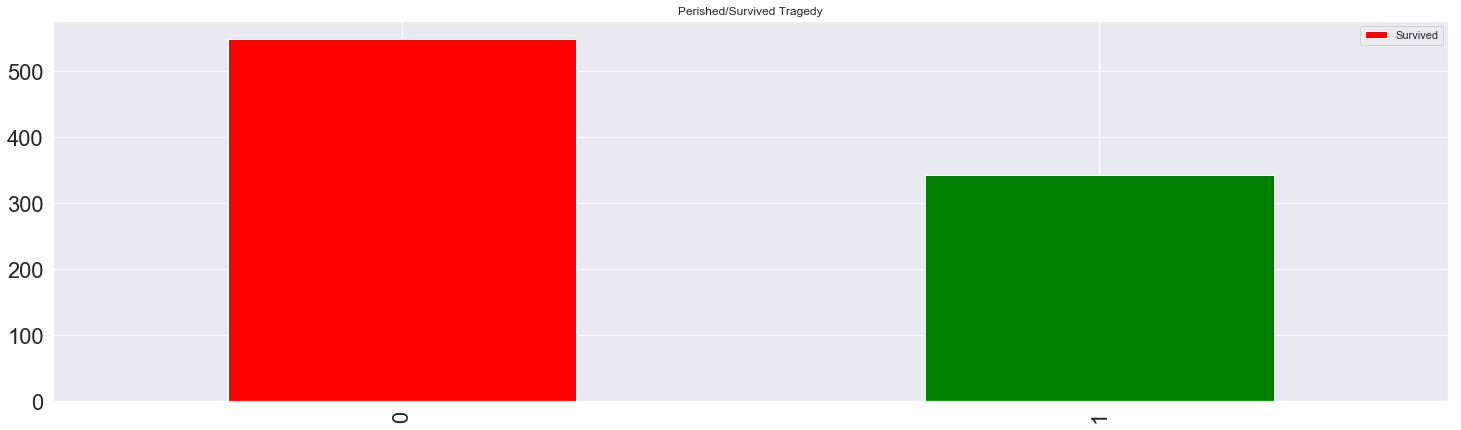

In [4]:
train = pd.read_csv('/home/bthomas/kaggle/titanic/data/train.csv')
test = pd.read_csv('/home/bthomas/kaggle/titanic/data/test.csv')
train['Survived'].value_counts().plot(kind='bar', 
                                       color=['Red', 'Green'], 
                                       title="Perished/Survived Tragedy", 
                                       legend=True, 
                                       figsize=(25,7),
                                       fontsize=22)

The training set ('train') shows a greater tendency toward a survival rate of being false within this set.

For this phase of the workflow, we will combine the data sets so that data transformations can be applied to both sets. A column will be added so that the original data set can be mapped later after featuring engineering.

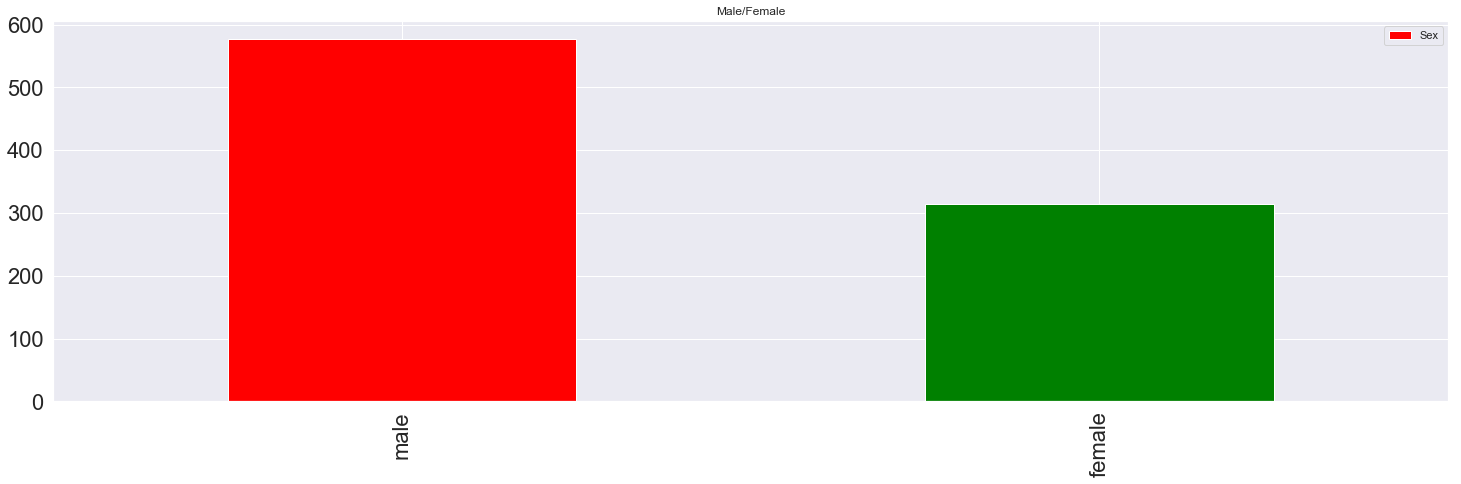

In [5]:
train['Sex'].value_counts().plot(kind='bar', 
                                       color=['Red', 'Green'], 
                                       title="Male/Female", 
                                       legend=True, 
                                       figsize=(25,7),
                                       fontsize=22)

More males are present in the training set which would seem to imply that the greater respresented population would have more survivors, however, the exploratory analysis shows that other factors contributed to survival.

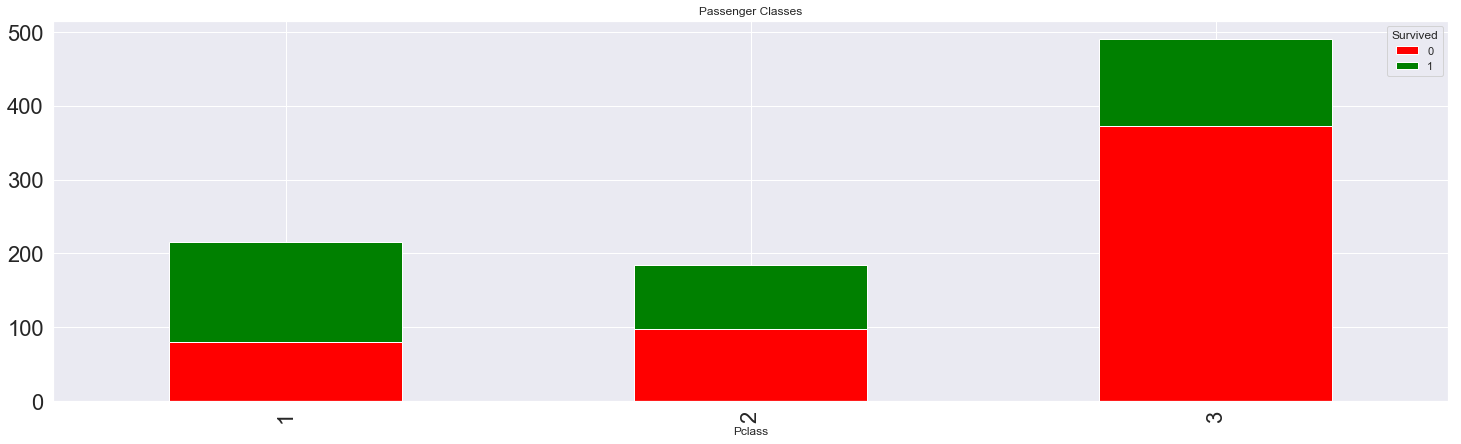

In [6]:
pd.crosstab(train.Pclass, train.Survived).plot(kind='bar', color=['Red', 'Green'], legend=True, title="Passenger Classes", stacked=True, figsize=(25, 7), fontsize=22)

The passenger class (Pclass) indicates that the third passenger class had the greatest lost of life.

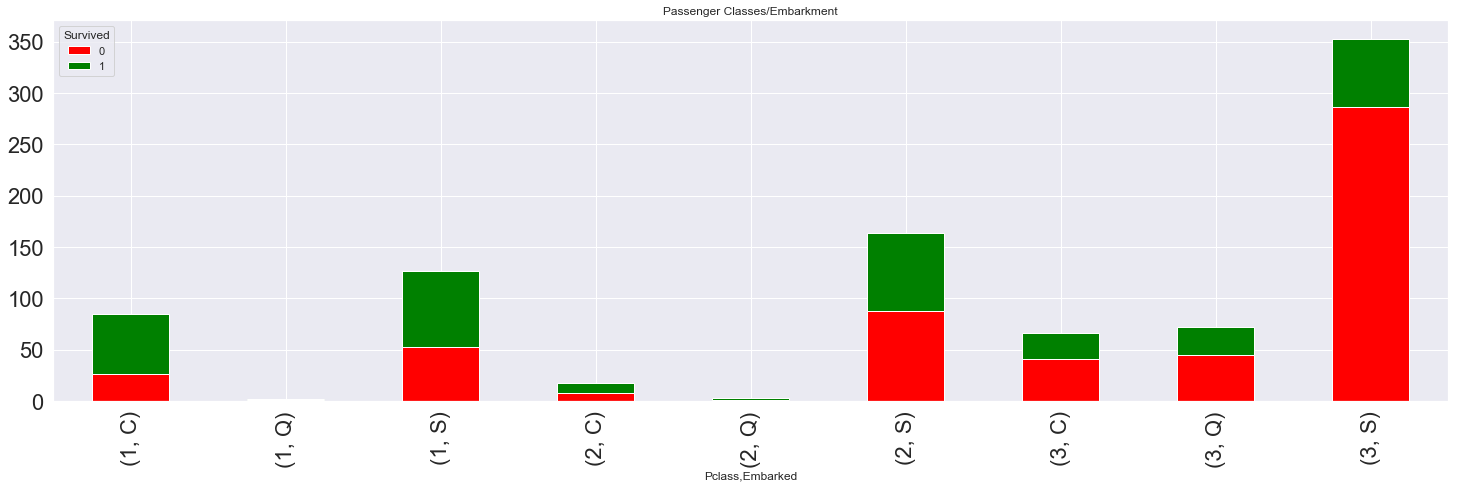

In [7]:
pd.crosstab([train.Pclass, train.Embarked], train.Survived).plot(kind='bar', color=['Red', 'Green'], legend=True, title="Passenger Classes/Embarkment", stacked=True, figsize=(25, 7), fontsize=22)

Third class tickets from embarkment point S had the greatest loss. Second class tickets embarking from S had greater deaths than third class tickets departing from C or Q.

In [8]:
# Combine the datasets so the transformation can be equally applied
train['DataSet'] = 'train'
test['DataSet'] = 'test'
combinedSet = pd.concat([train, test], sort=False)
combinedSet.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,DataSet
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


A check of the columns, we see that the name column and possibly ticket column have additional information. The name column is well formatted by last name, comma, title, and first name. In the case of married women, the husband's name is used. Ticket columns also may have information that would help expose more information. We will start by using regular expressions to extract the titles.

The regex search below says something like go to the first space, capture the first non white space, the plus means keep extracting, and the \. means stop extracting at the period.

In [9]:
import re
combinedSet['Title'] = ''
for index, t in combinedSet.iterrows():
    title_string = re.search(' (\S+)\.', t.Name).group(1)
    combinedSet.loc[index, 'Title'] = title_string

In [10]:
# compute the total number of passenger by using the sibling and parent columns
combinedSet['partySize'] = combinedSet['SibSp'] + combinedSet['Parch']
# compute the total number of passengers traveling on the same ticket
ticket_counts = combinedSet['Ticket'].value_counts()
ticket_counts_df = pd.DataFrame(ticket_counts)
ticket_count_df = ticket_counts_df.reset_index()
ticket_count_df.columns = ['Ticket', 'ticketCount']
combinedSetWithCounts = pd.merge(combinedSet, ticket_counts_df, left_on=combinedSet.Ticket, right_on=ticket_count_df.Ticket, how='outer')
combinedSetWithCounts = combinedSetWithCounts.sort_values(by=['key_0'])


In [11]:
# Fill in missing values
# Levels will be filled in with 'U' for unknown
combinedSetWithCounts.Fare = combinedSetWithCounts.fillna(combinedSetWithCounts.Fare.median())


In [12]:
combinedSetWithCounts = combinedSetWithCounts.drop(['PassengerId', 'Name', 'key_0'], axis=1)

In [13]:
combinedSetWithCounts.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket_x,Fare,Cabin,Embarked,DataSet,Title,partySize,Ticket_y
419,1.0,1,female,33.0,0,0,110152,110152,B77,S,train,Countess,0,3
418,1.0,1,female,16.0,0,0,110152,110152,B79,S,train,Miss,0,3
417,1.0,1,female,30.0,0,0,110152,110152,B77,S,train,Mr,0,3
429,1.0,1,female,18.0,0,2,110413,110413,E68,S,train,Miss,2,3
427,0.0,1,male,52.0,1,1,110413,110413,E67,S,train,Mrs,2,3


In reviewing the title counts for the combined set, we can see that some titles have opportunities to collapse into a high level lable. For example, Capt, Col, and Military are military titles.


In [14]:
Title_Dict = {
'Mr' : 'Mr',
'Miss' : 'Miss',
'Mrs' : 'Mrs',
'Master' : 'Child',
'Rev' : 'Professional',
'Dr' : 'Professional',
'Col' : 'Professional', 
'Ms' : 'Miss', 
'Major' : 'Professional',
'Mlle' : 'Miss', 
'Dona' : 'Society',
'Sir' : 'Society',
'Capt' : 'Professional',
'Jonkheer' : 'Society',
'Countess' : 'Society',
'Lady' : 'Society' 	
    
}
pd.DataFrame(list(Title_Dict.items()), columns=['Old', 'New'])['New'].value_counts()

Professional    5
Society         5
Miss            3
Child           1
Mrs             1
Mr              1
Name: New, dtype: int64

In [27]:
combinedSetWithCounts['Title'] = combinedSetWithCounts['Title'].map(Title_Dict)
combinedSetWithCounts[combinedSetWithCounts.Title.isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket_x,Fare,Cabin,Embarked,DataSet,Title,partySize,Ticket_y
419,1.0,1,female,33.00,0,0,110152,110152,B77,S,train,NaN,0,3
949,0.0,1,male,NaN,0,0,112379,112379,NaN,C,train,NaN,0,1
751,0.0,1,male,45.00,0,0,113050,113050,B38,S,train,NaN,0,1
600,1.0,1,male,11.00,1,2,113760,113760,B96 B98,S,train,NaN,3,4
1140,NaN,1,male,53.00,0,0,113780,113780,C51,C,test,NaN,0,1
540,0.0,1,male,45.00,0,0,113784,113784,T,S,train,NaN,0,1
666,1.0,1,male,52.00,0,0,113786,113786,C104,S,train,NaN,0,1
893,0.0,1,male,60.00,0,0,113800,113800,NaN,S,train,NaN,0,1
770,1.0,1,female,48.00,1,0,11755,11755,A16,C,train,NaN,1,1
851,1.0,1,male,56.00,0,0,13213,13213,A26,C,train,NaN,0,1


The map function above allows us to map titles to normalized categories.

Counting the number of passengers reveals that the passenger group is larger than relying on the sibling and parent columns. In looking at the cabin we see a letter which should correspond to the deck. We will next break tickets into letters and numbers.

Pclass, Age, and Fare will be evaluated for missing values. 1,309 rows with Pclass exists-- no missing data. 263 rows with missing ages were found. We created a table of mean ages by titles and then replace the missing age with lookup the mean age.


In [19]:
# Create a mean age lookup table and replace missing values with the mean
Age_Mean = combinedSetWithCounts.groupby('Title')[['Age']].mean()
Age_Mean = Age_Mean.reset_index()

    

In [ ]:
for index, r in combinedSetWithCounts.iterrows():
    if np.isnan(r['Age']):
        newAge = Age_Mean[Age_Mean.Title == r.Title]['Age']
        combinedSetWithCounts.loc[index, 'Age'] = float(newAge)

In [ ]:
combinedSetWithCounts.Embarked.isnull().any()

In [ ]:
combinedSetWithCounts['Level'] = combinedSetWithCounts.Cabin.str[:1]
combinedSetWithCounts.Level = combinedSetWithCounts.Level.fillna('U')
combinedSetWithCounts.Level.value_counts()

To evaluate the categorical columns we will convert the columns to dummy variables. fastML.com provides a great tutorial on using dummy variables. [5]

In [ ]:
combinedSetWithCounts = pd.get_dummies(data=combinedSetWithCounts, columns=['Sex', 'Embarked', 'Title', 'Level'])

In [ ]:

# Separate the combined sets
combinedSetWithCounts.columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket_x',
       'Fare', 'Cabin', 'Embarked', 'DataSet', 'Title', 'partySize',
       'GroupSize', 'Level']
combinedSetWithCounts.head()

partySize is the addition product of Parch and Sibsp. This means that the ticket grouping count, partySize, SibSp,and Parch are duplicate dimensions.

In [ ]:
combinedSetWithCounts = combinedSetWithCounts.drop(['partySize', 'SibSp', 'Parch'], axis=1)
combinedSetWithCounts.head()

In [ ]:
test = combinedSetWithCounts[combinedSetWithCounts.DataSet == 'test']
test = test.drop(['DataSet', 'Survived'], axis=1)
test.head()

In [ ]:
train = combinedSetWithCounts[combinedSetWithCounts.DataSet == 'train']
train = train.drop(['DataSet', 'Cabin', 'Ticket_x'], axis=1)
train.Survived = train.Survived.astype('int')
train.head()

In [ ]:
# This needs to be customized to the training set
corr = train.corr()
corr.style.background_gradient()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
targets = pd.read_csv('./data/train.csv', usecols=['Survived'])['Survived'].values

train.head()

In [ ]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)


# References
[1] Press, Gil, Cleaning Big Data: Most Time-Consuming, Least Enjoyable Data Science Task, Survey Says. Retrieved from https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#4a6b4e846f63 on November 22, 2018.

[2] triangleinequality for matters mathematical retrieved from https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/.

[3] https://www.coursera.org/learn/data-cleaning#%20.

[4] retrieved from http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.451.6606&rep=rep1&type=pdf 

[5] retrived from http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/
